In [1]:
%matplotlib inline

import itertools
import numpy as np
import os
import random
import sys
import psutil
import tensorflow as tf
from PIL import Image
from Agent import ObjLocaliser
import matplotlib.pyplot as plt
plt.switch_backend('agg')

if "./lib" not in sys.path:
    sys.path.append("./lib")

import plotting
from collections import deque, namedtuple
from readingFileEfficiently import *
import VOC2012_npz_files_writter

/home/mohammad/Tensorflow/local/lib/python2.7/site-packages/requests/__init__.py:83: RequestsDependencyWarning: Old version of cryptography ([1, 2, 3]) may cause slowdown.
  warnings.warn(warning, RequestsDependencyWarning)


In [2]:
#This cell reads VOC 2012 dataset and save them in .npz files for future.
#The process of reading data and put them in prper format is time consuming so they are stored in a file.

xml_path = "../VOC2012/Annotations/*.xml"
destination = "../data/"

#It splits dataset to 80% for training and 20% validation.
if not (os.path.isfile(destination+"test_input.npz") or os.path.isfile(destination+"test_target.npz")):
    VOC2012_npz_files_writter.writting_files(xml_path, destination, percentage=0)
    print("Files are ready!!!")
else:
    print("Records are already prepared!!!")

Records are already prepared!!!


In [3]:
# Atari Actions: 0 (noop), 1 (fire), 2 (left) and 3 (right) are valid actions
VALID_ACTIONS = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [4]:
class StateProcessor():
    """
    Processes a raw Atari images. Resizes it and converts it to grayscale.
    """
    def __init__(self):
        # Build the Tensorflow graph
        with tf.variable_scope("state_processor"):
            self.input_state = tf.placeholder(shape=[84, 84, 3], dtype=tf.uint8)
            self.output = tf.image.rgb_to_grayscale(self.input_state)
            #self.output = tf.image.crop_to_bounding_box(self.output, 34, 0, 160, 160)
            self.output = tf.image.resize_images(
                self.output, [84, 84], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
            self.output = tf.squeeze(self.output)

    def process(self, sess, state):
        """
        Args:
            sess: A Tensorflow session object
            state: A [210, 160, 3] Atari RGB State

        Returns:
            A processed [84, 84] state representing grayscale values.
        """
        return sess.run(self.output, { self.input_state: state })

In [5]:
class Estimator():
    """Q-Value Estimator neural network.

    This network is used for both the Q-Network and the Target Network.
    """

    def __init__(self, scope="estimator", summaries_dir=None):
        self.scope = scope
        # Writes Tensorboard summaries to disk
        self.summary_writer = None
        with tf.variable_scope(scope):
            # Build the graph
            self._build_model()
            if summaries_dir:
                summary_dir = os.path.join(summaries_dir, "summaries_{}".format(scope))
                if not os.path.exists(summary_dir):
                    os.makedirs(summary_dir)
                self.summary_writer = tf.summary.FileWriter(summary_dir) 
                # Old API:self.summary_writer = tf.train.SummaryWriter(summary_dir)

    def _build_model(self):
        """
        Builds the Tensorflow graph.
        """

        # Placeholders for our input
        # Our input are 4 RGB frames of shape 160, 160 each
        self.X_pl = tf.placeholder(shape=[None, 84, 84, 4], dtype=tf.uint8, name="X")
        # The TD target value
        self.y_pl = tf.placeholder(shape=[None], dtype=tf.float32, name="y")
        # Integer id of which action was selected
        self.actions_pl = tf.placeholder(shape=[None], dtype=tf.int32, name="actions")

        X = tf.to_float(self.X_pl) / 255.0
        batch_size = tf.shape(self.X_pl)[0]

        # Three convolutional layers
        conv1 = tf.contrib.layers.conv2d(
            X, 32, 8, 4, activation_fn=tf.nn.relu)
        conv2 = tf.contrib.layers.conv2d(
            conv1, 64, 4, 2, activation_fn=tf.nn.relu)
        conv3 = tf.contrib.layers.conv2d(
            conv2, 64, 3, 1, activation_fn=tf.nn.relu)

        # Fully connected layers
        flattened = tf.contrib.layers.flatten(conv3)
        fc1 = tf.contrib.layers.fully_connected(flattened, 512)
        self.predictions = tf.contrib.layers.fully_connected(fc1, len(VALID_ACTIONS))

        # Get the predictions for the chosen actions only
        gather_indices = tf.range(batch_size) * tf.shape(self.predictions)[1] + self.actions_pl
        self.action_predictions = tf.gather(tf.reshape(self.predictions, [-1]), gather_indices)

        # Calculate the loss
        self.losses = tf.squared_difference(self.y_pl, self.action_predictions)
        self.loss = tf.reduce_mean(self.losses)

        # Optimizer Parameters from original paper
        self.optimizer = tf.train.RMSPropOptimizer(0.00025, 0.99, 0.0, 1e-6)
        self.train_op = self.optimizer.minimize(self.loss, global_step=tf.contrib.framework.get_global_step())
        # Summaries for Tensorboard
        
        # Old APIs for using on cluster
        '''tf.scalar_summary("loss", self.loss, collections=['summ'])
        tf.histogram_summary("loss_hist", self.losses, collections=['summ'])
        tf.histogram_summary("q_values_hist", self.predictions, collections=['summ'])
        tf.scalar_summary("max_q_value", tf.reduce_max(self.predictions), collections=['summ'])
        self.summaries = tf.merge_all_summaries(key='summ')'''
        
        self.summaries = tf.summary.merge([ 
            tf.summary.scalar("loss", self.loss), 
            tf.summary.histogram("loss_hist", self.losses), 
            tf.summary.histogram("q_values_hist", self.predictions), 
            tf.summary.scalar("max_q_value", tf.reduce_max(self.predictions))
        ])

    def predict(self, sess, s):
        """
        Predicts action values.

        Args:
          sess: Tensorflow session
          s: State input of shape [batch_size, 4, 160, 160, 3]

        Returns:
          Tensor of shape [batch_size, NUM_VALID_ACTIONS] containing the estimated 
          action values.
        """
        return sess.run(self.predictions, { self.X_pl: s })

    def update(self, sess, s, a, y):
        """
        Updates the estimator towards the given targets.

        Args:
          sess: Tensorflow session object
          s: State input of shape [batch_size, 4, 160, 160, 3]
          a: Chosen actions of shape [batch_size]
          y: Targets of shape [batch_size]

        Returns:
          The calculated loss on the batch.
        """
        feed_dict = { self.X_pl: s, self.y_pl: y, self.actions_pl: a }
        summaries, global_step, _, loss = sess.run(
            [self.summaries, tf.contrib.framework.get_global_step(), self.train_op, self.loss],
            feed_dict)
        if self.summary_writer:
            # Old API for using on cluster
            self.summary_writer.add_summary(summaries, global_step)
            #self.summary_writer.add_summary(summaries, global_step.eval())
            
        return loss

In [6]:
class ModelParametersCopier():
    """
    Copy model parameters of one estimator to another.
    """
    
    def __init__(self, estimator1, estimator2):
        """
        Defines copy-work operation graph.  
        Args:
          estimator1: Estimator to copy the paramters from
          estimator2: Estimator to copy the parameters to
        """
        e1_params = [t for t in tf.trainable_variables() if t.name.startswith(estimator1.scope)]
        e1_params = sorted(e1_params, key=lambda v: v.name)
        e2_params = [t for t in tf.trainable_variables() if t.name.startswith(estimator2.scope)]
        e2_params = sorted(e2_params, key=lambda v: v.name)

        self.update_ops = []
        for e1_v, e2_v in zip(e1_params, e2_params):
            op = e2_v.assign(e1_v)
            self.update_ops.append(op)
            
    def make(self, sess):
        """
        Makes copy.
        Args:
            sess: Tensorflow session instance
        """
        sess.run(self.update_ops)

In [7]:
def make_epsilon_greedy_policy(estimator, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function approximator and epsilon.

    Args:
        estimator: An estimator that returns q values for a given state
        nA: Number of actions in the environment.

    Returns:
        A function that takes the (sess, observation, epsilon) as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.

    """
    def policy_fn(sess, observation, epsilon):
        A = np.ones(nA, dtype=float) * epsilon / nA
        q_values = estimator.predict(sess, np.expand_dims(observation, 0))[0]
        best_action = np.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [8]:
num_episodes=10  #200     
replay_memory_size=500000    #2500   
replay_memory_init_size=500 #500  
update_target_estimator_every=10000 #100  
discount_factor=0.99
epsilon_start=1.0
epsilon_end=0.1
epsilon_decay_steps=500000 #10000  
batch_size=32
category = "cat"

#model_name = "defaul_DQL_architecture_epis{}_memorySize{}_UTE{}_EDS{}".format(num_episodes, replay_memory_size, update_target_estimator_every, epsilon_decay_steps)
model_name = "cats"


tf.reset_default_graph()

# Where we save our checkpoints and graphs
experiment_dir = os.path.abspath("./experiments/{}".format(model_name))

# Create a glboal step variable
global_step = tf.Variable(0, name='global_step', trainable=False)
    
# Create estimators
q_estimator = Estimator(scope="q_estimator", summaries_dir=experiment_dir)
target_estimator = Estimator(scope="target_q")

# State processor
state_processor = StateProcessor()



done = False
elist = []
rlist = []


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer()) 
    # Old API: sess.run(tf.initialize_all_variables())  
    Transition = namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])

    # The replay memory
    replay_memory = []
    
    num_located = 0

    # Make model copier object
    estimator_copy = ModelParametersCopier(q_estimator, target_estimator)

    # Keeps track of useful statistics
    #stats = plotting.EpisodeStats(
        #episode_lengths=np.zeros(num_episodes),
        #episode_rewards=np.zeros(num_episodes))

    # For 'system/' summaries, usefull to check if currrent process looks healthy
    current_process = psutil.Process()

    # Create directories for checkpoints and summaries
    checkpoint_dir = os.path.join(experiment_dir, "checkpoints")
    checkpoint_path = os.path.join(checkpoint_dir, "model")
    report_path = os.path.join(experiment_dir, "report")

    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    if not os.path.exists(report_path):
        os.makedirs(report_path)
    f = open(report_path+"/log.txt", 'w')
    saver = tf.train.Saver()
    # Load a previous checkpoint if we find one
    latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
    if latest_checkpoint:
        print("Loading model checkpoint {}...\n".format(latest_checkpoint))
        saver.restore(sess, latest_checkpoint)

    # Get the current time step
    total_t = sess.run(tf.contrib.framework.get_global_step())
    #print "init:{}".format(total_t)

    # The epsilon decay schedule
    epsilons = np.linspace(epsilon_start, epsilon_end, epsilon_decay_steps)

    # The policy we're following
    policy = make_epsilon_greedy_policy(
        q_estimator,
        len(VALID_ACTIONS))
    episode_counter = 0
    #mybreak = 0
    
    for indx,tmp in enumerate(extractData(category, "train", batch_size)):

        #if mybreak > 5:
            #break
        
        img=tmp[0]
        target=tmp[1]

        im2 = Image.frombytes("RGB",(img['image_width'],img['image_height']),img['image'])
        env = ObjLocaliser(np.array(im2),target)
        print "New image is being loaded: {}".format(img['image_filename'])
        
        if len(replay_memory) < replay_memory_init_size:
            
            # Populate the replay memory with initial experience
            print("Populating replay memory...\n")

            env.Reset(np.array(im2))
            state = env.wrapping()


            state = state_processor.process(sess, state)
            state = np.stack([state] * 4, axis=2)

            for i in range(replay_memory_init_size):

                #env.Reset(np.array(im2))
                #state = env.wrapping()
                #state = state_processor.process(sess, state)
                #state = np.stack([state] * 4, axis=2)
                #action = 0
                #counter = 0
                #done = False

                #while (action != 10) or (counter < 50):

                action_probs = policy(sess, state, epsilons[min(total_t, epsilon_decay_steps-1)])
                action = np.random.choice(np.arange(len(action_probs)), p=action_probs)

                #next_state, reward, done, _ = env.step(VALID_ACTIONS[action])
                reward = env.takingActions(VALID_ACTIONS[action])
                next_state = env.wrapping()

                if action == 10:
                    done = True
                else: 
                    done = False

                next_state = state_processor.process(sess, next_state)
                next_state = np.append(state[:,:,1:], np.expand_dims(next_state, 2), axis=2)
                replay_memory.append(Transition(state, action, reward, next_state, done))
                state = next_state

                #counter += 1

                if done:
                    #state = env.reset()
                    env.Reset(np.array(im2))
                    state = env.wrapping()
                    state = state_processor.process(sess, state)
                    state = np.stack([state] * 4, axis=2)
                else:
                    state = next_state 
            
            
            
    
        for i_episode in range(num_episodes):

            # Save the current checkpoint
            saver.save(tf.get_default_session(), checkpoint_path)

            # Reset the environment
            #state = env.reset()
            env.Reset(np.array(im2))
            state = env.wrapping()
            state = state_processor.process(sess, state)
            state = np.stack([state] * 4, axis=2)
            loss = None
            t=0
            action = 0
            e = 0
            r = 0
            #done = False
            # One step in the environment
            while (action != 10) and (t < 50):
                #print "hello22:{}".format(loss)
                #env.drawActions()
                # Epsilon for this time step
                epsilon = epsilons[min(total_t, epsilon_decay_steps-1)]

                # Maybe update the target estimator
                if total_t % update_target_estimator_every == 0:
                    estimator_copy.make(sess)
                    print("\nCopied model parameters to target network.")

                # Print out which step we're on, useful for debugging.
                #sys.stdout.flush()

                # Take a step
                #print epsilon
                action_probs = policy(sess, state, epsilon)
                action = np.random.choice(np.arange(len(action_probs)), p=action_probs)


                #next_state, reward, done, _ = env.step(VALID_ACTIONS[action])
                reward = env.takingActions(VALID_ACTIONS[action])
                next_state = env.wrapping()
                if action == 10:
                    done = True
                else: 
                    done = False


                next_state = state_processor.process(sess, next_state)
                next_state = np.append(state[:,:,1:], np.expand_dims(next_state, 2), axis=2)

                # If our replay memory is full, pop the first element
                if len(replay_memory) == replay_memory_size:
                    replay_memory.pop(0)

                # Save transition to replay memory
                replay_memory.append(Transition(state, action, reward, next_state, done))   
                # Update statistics
                #stats.episode_rewards[i_episode] += reward
                #stats.episode_lengths[i_episode] = t

                # Sample a minibatch from the replay memory
                samples = random.sample(replay_memory, batch_size)
                states_batch, action_batch, reward_batch, next_states_batch, done_batch = map(np.array, zip(*samples))

                # Calculate q values and targets
                q_values_next = target_estimator.predict(sess, next_states_batch)
                targets_batch = reward_batch + np.invert(done_batch).astype(np.float32) * discount_factor * np.amax(q_values_next, axis=1)

                # Perform gradient descent update
                states_batch = np.array(states_batch)
                loss = q_estimator.update(sess, states_batch, action_batch, targets_batch)
                print("Step {} ({}) @ Episode {}/{}, action {}, reward {},loss: {}".format(t, total_t, i_episode + 1, num_episodes, action, reward, loss))
                f.write("Step {} ({}) @ Episode {}/{}, action {}, reward {},loss: {}\n".format(t, total_t, i_episode + 1, num_episodes, action, reward, loss))     


                # Counting number of correct localsied objects
                if reward == 3:
                    num_located += 1

                state = next_state
                t += 1
                total_t += 1
                e = e + loss
                r = r + reward
        
            episode_counter += 1

            # Add summaries to tensorboard
            episode_summary = tf.Summary()
            episode_summary.value.add(simple_value=epsilon, tag="episode/epsilon")
            episode_summary.value.add(simple_value=r, tag="episode/reward")
            episode_summary.value.add(simple_value=t, tag="episode/length")
            episode_summary.value.add(simple_value=current_process.cpu_percent(), tag="system/cpu_usage_percent")
            episode_summary.value.add(simple_value=current_process.memory_percent(), tag="system/v_memeory_usage_percent")
            q_estimator.summary_writer.add_summary(episode_summary, episode_counter)
            q_estimator.summary_writer.flush()

            #prin_stats = plotting.EpisodeStats(
                #episode_lengths=stats.episode_lengths[:i_episode+1],
                #episode_rewards=stats.episode_rewards[:i_episode+1])

            #print("Episode Reward: {} Episode Length: {}".format(prin_stats.episode_rewards[-1], prin_stats.episode_lengths[-1]))
            #f.write("Episode Reward: {} Episode Length: {}".format(prin_stats.episode_rewards[-1], prin_stats.episode_lengths[-1]))
            print("Episode Reward: {} Episode Length: {}".format(r, t))
            f.write("Episode Reward: {} Episode Length: {}".format(r, t))

            elist.append(float(e)/t)
            rlist.append(float(r)/t)
        #mybreak += 1

        
f.close()
print "number of correct located objects:{}".format(num_located)

Instructions for updating:
Please switch to tf.train.get_global_step


/home/mohammad/Tensorflow/local/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


input file 1 is loading...
New image is being loaded: 2010_002425.jpg
Populating replay memory...


Copied model parameters to target network.
Step 0 (0) @ Episode 1/10, action 1, reward 1,loss: 1.2331610918
Step 1 (1) @ Episode 1/10, action 9, reward -1,loss: 1.98210096359
Step 2 (2) @ Episode 1/10, action 1, reward 1,loss: 1.24116551876
Step 3 (3) @ Episode 1/10, action 9, reward -1,loss: 1.74392306805
Step 4 (4) @ Episode 1/10, action 8, reward -1,loss: 1.71541273594
Step 5 (5) @ Episode 1/10, action 0, reward 1,loss: 2.23642301559
Step 6 (6) @ Episode 1/10, action 3, reward 1,loss: 1.43854832649
Step 7 (7) @ Episode 1/10, action 6, reward -1,loss: 1.6975338459
Step 8 (8) @ Episode 1/10, action 7, reward 1,loss: 1.2195879221
Step 9 (9) @ Episode 1/10, action 9, reward -1,loss: 1.51468324661
Step 10 (10) @ Episode 1/10, action 3, reward -1,loss: 1.95084214211
Step 11 (11) @ Episode 1/10, action 9, reward -1,loss: 1.96241784096
Step 12 (12) @ Episode 1/10, action 5, reward -1,loss: 1.

Step 44 (116) @ Episode 7/10, action 6, reward -1,loss: 1.44343137741
Step 45 (117) @ Episode 7/10, action 10, reward -3,loss: 1.68776702881
Episode Reward: -10 Episode Length: 46
Step 0 (118) @ Episode 8/10, action 10, reward 3,loss: 1.20095646381
Episode Reward: 3 Episode Length: 1
Step 0 (119) @ Episode 9/10, action 7, reward 1,loss: 1.42139196396
Step 1 (120) @ Episode 9/10, action 9, reward -1,loss: 1.0049675703
Step 2 (121) @ Episode 9/10, action 0, reward 1,loss: 1.42158555984
Step 3 (122) @ Episode 9/10, action 5, reward -1,loss: 1.6552426815
Step 4 (123) @ Episode 9/10, action 5, reward -1,loss: 1.41574215889
Step 5 (124) @ Episode 9/10, action 6, reward -1,loss: 0.92316699028
Step 6 (125) @ Episode 9/10, action 6, reward -1,loss: 1.92159533501
Step 7 (126) @ Episode 9/10, action 10, reward -3,loss: 1.13897013664
Episode Reward: -6 Episode Length: 8
Step 0 (127) @ Episode 10/10, action 9, reward 1,loss: 1.65645205975
Step 1 (128) @ Episode 10/10, action 0, reward 1,loss: 1.217

Step 0 (228) @ Episode 8/10, action 2, reward 1,loss: 2.15983581543
Step 1 (229) @ Episode 8/10, action 2, reward -1,loss: 2.17555785179
Step 2 (230) @ Episode 8/10, action 8, reward 1,loss: 1.69132494926
Step 3 (231) @ Episode 8/10, action 10, reward -3,loss: 1.9595233202
Episode Reward: -2 Episode Length: 4
Step 0 (232) @ Episode 9/10, action 9, reward 1,loss: 0.954539656639
Step 1 (233) @ Episode 9/10, action 4, reward -1,loss: 1.93717646599
Step 2 (234) @ Episode 9/10, action 3, reward 1,loss: 1.16287493706
Step 3 (235) @ Episode 9/10, action 7, reward -1,loss: 1.43912291527
Step 4 (236) @ Episode 9/10, action 2, reward -1,loss: 1.42618513107
Step 5 (237) @ Episode 9/10, action 1, reward 1,loss: 0.94421350956
Step 6 (238) @ Episode 9/10, action 1, reward -1,loss: 0.883976101875
Step 7 (239) @ Episode 9/10, action 3, reward -1,loss: 1.70837438107
Step 8 (240) @ Episode 9/10, action 6, reward 1,loss: 1.38896179199
Step 9 (241) @ Episode 9/10, action 1, reward -1,loss: 1.44475138187
S

Step 8 (340) @ Episode 10/10, action 2, reward 1,loss: 1.20474982262
Step 9 (341) @ Episode 10/10, action 10, reward -3,loss: 2.19458723068
Episode Reward: 0 Episode Length: 10
New image is being loaded: 2008_007702.jpg
Step 0 (342) @ Episode 1/10, action 6, reward 1,loss: 1.92318761349
Step 1 (343) @ Episode 1/10, action 7, reward 1,loss: 1.62478029728
Step 2 (344) @ Episode 1/10, action 10, reward -3,loss: 1.90393388271
Episode Reward: -1 Episode Length: 3
Step 0 (345) @ Episode 2/10, action 7, reward 1,loss: 1.16832470894
Step 1 (346) @ Episode 2/10, action 10, reward -3,loss: 1.88060975075
Episode Reward: -2 Episode Length: 2
Step 0 (347) @ Episode 3/10, action 6, reward 1,loss: 2.01696372032
Step 1 (348) @ Episode 3/10, action 10, reward -3,loss: 1.84098494053
Episode Reward: -2 Episode Length: 2
Step 0 (349) @ Episode 4/10, action 7, reward 1,loss: 1.16383051872
Step 1 (350) @ Episode 4/10, action 9, reward -1,loss: 1.8729186058
Step 2 (351) @ Episode 4/10, action 0, reward 1,los

Step 2 (451) @ Episode 3/10, action 2, reward -1,loss: 1.16107785702
Step 3 (452) @ Episode 3/10, action 9, reward -1,loss: 1.4136121273
Step 4 (453) @ Episode 3/10, action 4, reward -1,loss: 1.3785443306
Step 5 (454) @ Episode 3/10, action 0, reward 1,loss: 2.44380354881
Step 6 (455) @ Episode 3/10, action 4, reward -1,loss: 1.96283948421
Step 7 (456) @ Episode 3/10, action 6, reward -1,loss: 1.65313339233
Step 8 (457) @ Episode 3/10, action 3, reward 1,loss: 1.40713000298
Step 9 (458) @ Episode 3/10, action 8, reward -1,loss: 1.65381658077
Step 10 (459) @ Episode 3/10, action 4, reward -1,loss: 1.25205183029
Step 11 (460) @ Episode 3/10, action 3, reward 1,loss: 1.18697679043
Step 12 (461) @ Episode 3/10, action 5, reward -1,loss: 2.20678544044
Step 13 (462) @ Episode 3/10, action 7, reward 1,loss: 1.6343473196
Step 14 (463) @ Episode 3/10, action 9, reward -1,loss: 1.39811825752
Step 15 (464) @ Episode 3/10, action 4, reward -1,loss: 1.63840758801
Step 16 (465) @ Episode 3/10, actio

Step 0 (564) @ Episode 2/10, action 5, reward 1,loss: 1.43789434433
Step 1 (565) @ Episode 2/10, action 0, reward -1,loss: 2.00958776474
Step 2 (566) @ Episode 2/10, action 3, reward -1,loss: 1.38604128361
Step 3 (567) @ Episode 2/10, action 7, reward -1,loss: 1.52093911171
Step 4 (568) @ Episode 2/10, action 6, reward -1,loss: 1.39241313934
Step 5 (569) @ Episode 2/10, action 7, reward 1,loss: 1.15261161327
Step 6 (570) @ Episode 2/10, action 8, reward -1,loss: 1.3918210268
Step 7 (571) @ Episode 2/10, action 4, reward -1,loss: 1.2399340868
Step 8 (572) @ Episode 2/10, action 9, reward -1,loss: 1.11801242828
Step 9 (573) @ Episode 2/10, action 5, reward -1,loss: 2.65685415268
Step 10 (574) @ Episode 2/10, action 8, reward -1,loss: 1.54456222057
Step 11 (575) @ Episode 2/10, action 1, reward 1,loss: 1.6922454834
Step 12 (576) @ Episode 2/10, action 3, reward 1,loss: 1.16673481464
Step 13 (577) @ Episode 2/10, action 6, reward -1,loss: 1.03930270672
Step 14 (578) @ Episode 2/10, action 

Step 2 (680) @ Episode 10/10, action 8, reward -1,loss: 1.67076992989
Step 3 (681) @ Episode 10/10, action 1, reward -1,loss: 1.43415570259
Step 4 (682) @ Episode 10/10, action 4, reward -1,loss: 1.21595108509
Step 5 (683) @ Episode 10/10, action 3, reward -1,loss: 0.940715312958
Step 6 (684) @ Episode 10/10, action 7, reward 1,loss: 1.18463528156
Step 7 (685) @ Episode 10/10, action 6, reward -1,loss: 1.82160687447
Step 8 (686) @ Episode 10/10, action 4, reward -1,loss: 1.63048315048
Step 9 (687) @ Episode 10/10, action 7, reward 1,loss: 2.57182693481
Step 10 (688) @ Episode 10/10, action 0, reward 1,loss: 1.44679605961
Step 11 (689) @ Episode 10/10, action 5, reward -1,loss: 1.69984507561
Step 12 (690) @ Episode 10/10, action 9, reward -1,loss: 1.87990963459
Step 13 (691) @ Episode 10/10, action 10, reward -3,loss: 0.915189385414
Episode Reward: -8 Episode Length: 14
number of correct located objects:6


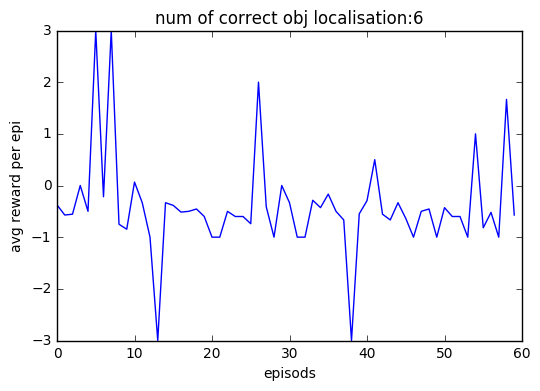

In [9]:
plt.xlabel("episods")
plt.ylabel("avg reward per epi")
plt.title("num of correct obj localisation:{0}".format(num_located))
plt.plot(rlist)
plt.savefig("./graphs/reward")
plt.close()

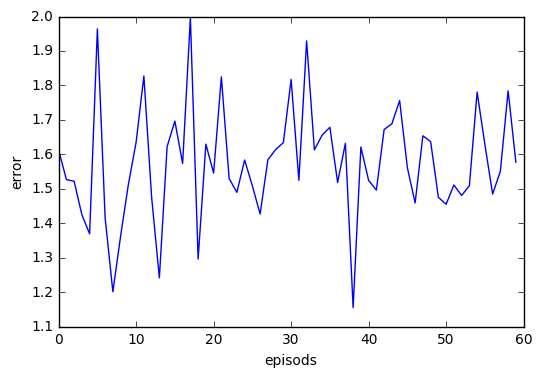

In [10]:
plt.xlabel("episods")
plt.ylabel("error")
plt.plot(elist)
plt.savefig("./graphs/error")

link to code: https://github.com/dennybritz/reinforcement-learning/blob/master/DQN/Deep%20Q%20Learning%20Solution.ipynb

https://www.oreilly.com/ideas/reinforcement-learning-with-tensorflow